<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

## Config

In [1]:
repo='https://github.com/avinashmane/colab.git'
import os,sys
if os.name=='nt':
    LIB= r'c:\m\lib'
    LOG= r'c:\m\social-media-automation'
    AUTH= r'c:\i\auth'
    sys.path.append("./lib")
else:
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    LIB='/content/drive/MyDrive/m/lib'
    LOG='/content/drive/MyDrive/m/lib'
    AUTH='/content/drive/MyDrive/m/auth'
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    if not os.path.exists('repo'):
      !git clone $repo repo
    sys.path.append('repo')
    sys.path.append("repo/lib")
sys.path.append(LIB)


In [2]:
import yaml
cfg=yaml.load(u"""
repo:
    https://github.com/avinashmane/colab.git
packages: 
- chromium-chromedriver
modules:
- nerodia
- pygsheets
env:
    nt:
        LIB: c:/m/lib
        LOG: c:/m/social-media-automation
        AUTH: c:/i/auth
    posix:
        LIB: /content/drive/MyDrive/m/lib
        LOG: /content/drive/MyDrive/m/lib
        AUTH: /content/drive/MyDrive/m/auth
sheets:
    stravasync:
        url: https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit#gid=0
        tab: Members
        range: A10:O
    StravaPromoLog:
        url: https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit#gid=0
        tab: StravaPromoLog
        
""",Loader=yaml.Loader)
for x in cfg['env'][os.name]: 
    os.environ[x]=eval(x)

import importlib
import utils
importlib.reload(utils)
utils.setup_env(cfg['packages'],cfg['modules'])

'Environment setup'

## Code

In [3]:
import yaml
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image

import utils

import socialmediasite 
importlib.reload(socialmediasite)
Linkedin=socialmediasite.Linkedin

# Process
## Create headless

In [4]:
" Test Selenium headless"
if True:#'b' in globals():
    if os.name=='nt':
        b=Browser('chrome',)
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    
    utils.setLogger(f"{LOG}/strava-automation.log")
    

2022-08-19 11:34:35:INFO:Logger file: c:\m\social-media-automation/strava-automation.log


In [5]:
# %debug
# if os.name=='nt':
nerodia.default_timeout=3
li=Linkedin(b,authFile=f'{AUTH}/auth.yaml')


In [6]:
li.login("avinash")

In [7]:
li.browser.url

'https://www.linkedin.com/feed/'

In [22]:
li.scrolldown(9)

In [23]:
importlib.reload(socialmediasite )
import socialmediasite

li=Linkedin(b,authFile=f'{AUTH}/auth.yaml')
utils.setLogger(f"{LOG}/strava-automation.log")

import pandas as pd
# .div(class_name='scaffold-finite-scroll').
nerodia.default_timeout=.1

def getPostData(postTag):
  "Return data regarding one post in linkedin feed"
  post={}
  if not postTag.exists:
    return
  _map={
      'post':'postTag.parent().element(class_name="visually-hidden").text',
      'urn':'postTag.attributes["data_urn"]',
      'name':'postTag.element(class_name="feed-shared-actor__name").text',
      'userUrl':'postTag.link(class_name="feed-shared-actor__container-link").href',
      'likes':'postTag.element(class_name="social-details-social-counts__reactions-count").text',
        # len('.div(class_name='feed-shared-social-actions').buttons(text='Like'))',
          # 'react-button--active' in 'react-button__text--like' in 
      'liked':'"react-button--active" in postTag.div(class_name="feed-shared-social-actions").button(text="Like").class_name',
      # print(name','.element(class_name='feed-shared-social-actions'
      #                                                            ).button(text='Like').class_name)
      'text':'postTag.element(class_name="feed-shared-update-v2__commentary").text',
      'desc':'postTag.element(class_name="feed-shared-actor__description").text',
      'subdesc':'postTag.element(class_name="feed-shared-actor__sub-description").text',
      # if post['subdesc'] not in ['Promoted']:
      'deg':'postTag.span(class_name="feed-shared-actor__supplementary-actor-info").text',
  }

  for _v,_e in _map.items():
    try:
        _m = re.search(r'.*(postTag\..*\))',_e)
        if _m:
            if eval(_m.group(1)+".exists"):
                post[_v]=eval(_e,{"postTag":postTag})
    except Exception as e:
        pass
        print(f"error {e!r} {_v} {_e}")
    
    if 'text' in post : post['text']=post['text'][:40]
    if 'userUrl' in post : post['userUrl']=post['userUrl'].split("?")[0]
    # post['liked']='react-button--active' in postTag.div(class_name='feed-shared-social-actions'
    #                                                          ).button(text='Like').class_name

  return post    

def getPostIds():
  "Get list of all feed posts"
  nerodia.default_timeout=.1
  posts=[]

  for x in b.elements(class_name='feed-shared-update-v2',
                      ):#data_id=re.compile("urn:li:activity:")):
    if re.match(r"^urn:li:activity:",x.data_urn):
        try:
            post=getPostData(x)
            post.update({'el':x})
            posts.append( post)
        except Exception as e:
          # Logs the error appropriately. 
            print(f">>{e!r}")

  return posts

posts = getPostIds() #li.


# posts=[]

# i=0
# for x in b.elements(class_name='feed-shared-update-v2',
#                     data_urn=re.compile("urn:li:activity:"),
#                    ):#data_id=re.compile("urn:li:activity:")):
#     # print (">>>",x.link(class_name="feed-shared-actor__container-link").href)
#     try:
#         print(x.h2(class_name="visually-hidden").text)
#         post=li.getPostData(x)
#         posts.append(post)
#     except Exception as e:
#         print(f"Error: {e!r}")
    # if i>3: 
    #     break
    # else:
    #     i+=1
# display (pd.DataFrame(posts))

2022-08-19 14:24:11:INFO:Logger file: c:\m\social-media-automation/strava-automation.log


In [24]:
"list posts"
display (pd.DataFrame(posts)[['name','deg','text','liked']].style)

,name,deg,text,liked
0,Jairaj Asok Kumar,• 1st,Surprise gift from IBM. Thank you leader,False
1,Bain & Company,nan,#Cloud platforms and #IoT providers emer,False
2,Suresh Karupakula,• 1st,Merchandising Engineering within Kroger,False
3,Magic Software Enterprises,nan,System integration is essential to reap,False
4,Aviation Talk,nan,The only passenger I want looking at me,False
5,James Nanscawen,• 1st,Thrilled to be joining an exciting lineu,False
6,Arvind Kejriwal,• 3rd+,Delhi has made India proud. Delhi model,False
7,KPMG,nan,Fast-maturing customers are increasingly,False
8,"Amit Das, PMP®",• 2nd,"It's back and in person, after a gap of",False
9,"Lakshmi N Koya FCWA.CMA,CPA,EA,PMP",• 1st,We developed Integrated demo that gets t,False


In [25]:
for p in posts:
    if ('deg' in p and 
        (p['deg']=='• 1st')):
        p['text']=p['text'] if 'text' in p else ''
        if(not p['liked']):
            _likeButton=p['el'].div(class_name='feed-shared-social-actions'
                                  ).button(text='Like')
            if _likeButton.exists:  
                logging.info(f"Liking {p['name']} {p['text'][:30]}")
                try:
                    # _likeButton.click()
                    _likeButton.execute_script("arguments[0].click();", _likeButton)
                except Exception as e:
                  # Logs the error appropriately. 
                    print(f">>{e!r}")
        else:
            logging.warning(f"already liked {p['name']} {p['text'][:30]}")
    else:
        logging.warning(f"not 1st connection {p['name']}")


2022-08-19 14:26:11:INFO:Liking Jairaj Asok Kumar Surprise gift from IBM. Thank 
2022-08-19 14:26:11:WARNING:not 1st connection Bain & Company
2022-08-19 14:26:12:INFO:Liking Suresh Karupakula Merchandising Engineering with
2022-08-19 14:26:12:WARNING:not 1st connection Magic Software Enterprises
2022-08-19 14:26:12:WARNING:not 1st connection Aviation Talk
2022-08-19 14:26:12:INFO:Liking James Nanscawen Thrilled to be joining an exci
2022-08-19 14:26:12:WARNING:not 1st connection Arvind Kejriwal
2022-08-19 14:26:12:WARNING:not 1st connection KPMG
2022-08-19 14:26:12:WARNING:not 1st connection Amit Das, PMP®
2022-08-19 14:26:12:INFO:Liking Lakshmi N Koya FCWA.CMA,CPA,EA,PMP We developed Integrated demo t
2022-08-19 14:26:12:WARNING:not 1st connection Sonal Sinha
2022-08-19 14:26:12:WARNING:not 1st connection TalentSprint
2022-08-19 14:26:12:WARNING:not 1st connection Mrinalini Vats
2022-08-19 14:26:12:WARNING:not 1st connection Tracy Jefferson
2022-08-19 14:26:12:INFO:Liking Swapneil De

In [12]:
"logout"
# li.logout()

'logout'

# test linkedin

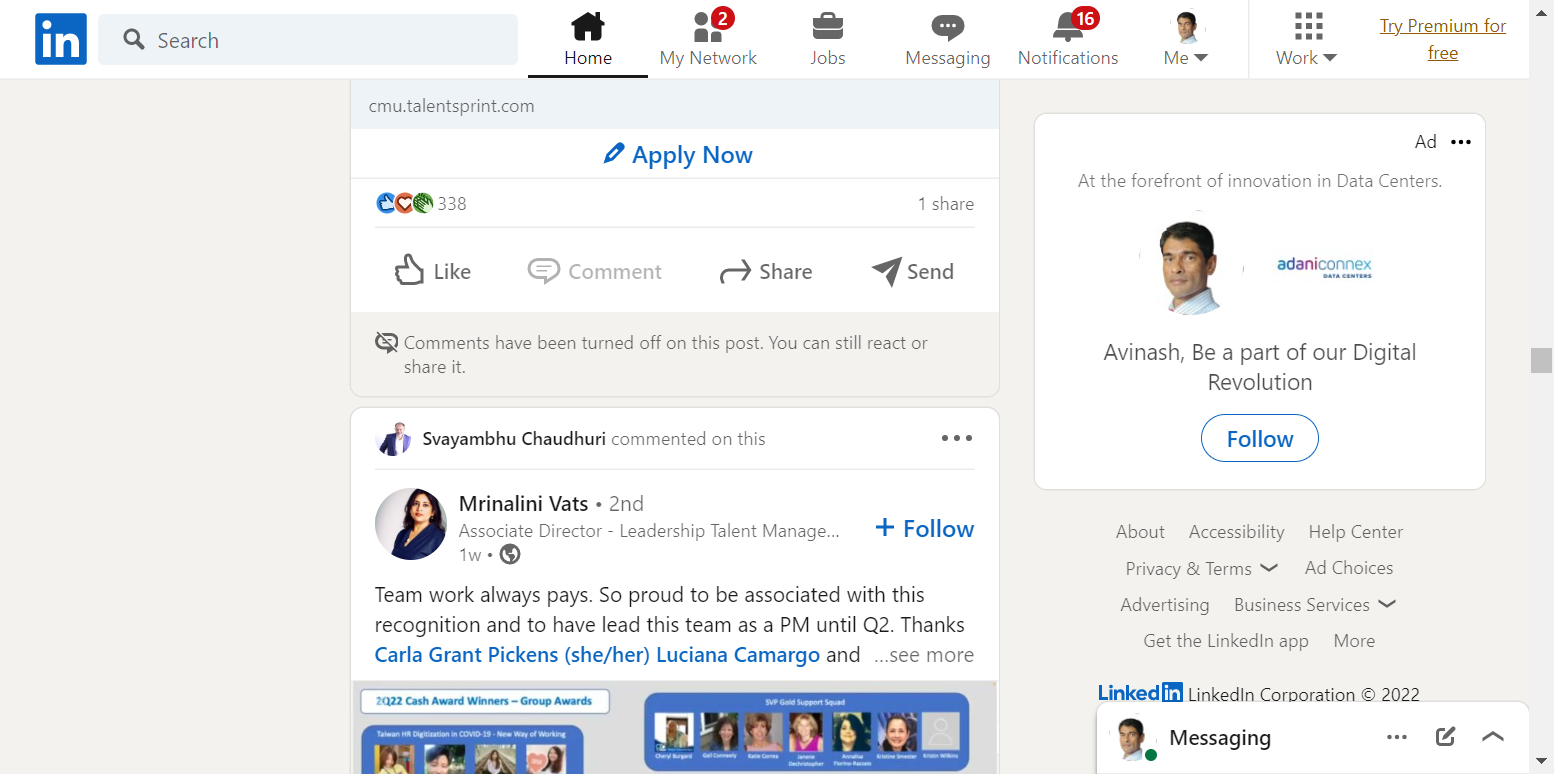

In [26]:

Image(b.screenshot.png())

## A. Give likes in feed